In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import xarray as xr

import fields
import model
import prediction
import plot

%matplotlib inline

In [3]:
ds = xr.open_dataset("../data/exp_pro/OCO2_MODIS_4x5deg_monthly_conus_augmented.nc")
ds = ds.where(ds.time.dt.year > 2014, drop=True)

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var", "evi"]]

datasets = [ds_xco2, ds_sif]
covariates = [["lon", "lat"], ["evi"]]
timedeltas = [0, -1]
vario_config = fields.VarioConfig(1500, 30)

In [4]:
mf = fields.MultiField(
        datasets, covariates, np.datetime64("2016-08-01"), timedeltas
    )
gamma = mf.empirical_variograms(vario_config)

## Fitting
---

In [5]:
mod = model.FullBivariateMatern()
mod.fit(gamma)
mod.params.to_dataframe()

,name,value,bounds
0,sigma_11,1.022804,"(0.4, 3.5)"
1,sigma_22,1.111082,"(0.4, 3.5)"
2,nu_11,0.761062,"(0.2, 3.5)"
3,nu_12,3.500000,"(0.2, 3.5)"
4,nu_22,0.865863,"(0.2, 3.5)"
5,len_scale_11,366.394072,"(100.0, 2000.0)"
6,len_scale_12,2000.000000,"(100.0, 2000.0)"
7,len_scale_22,665.881210,"(100.0, 2000.0)"
8,nugget_11,0.057784,"(0.0, 0.2)"
9,nugget_22,0.025702,"(0.0, 0.2)"


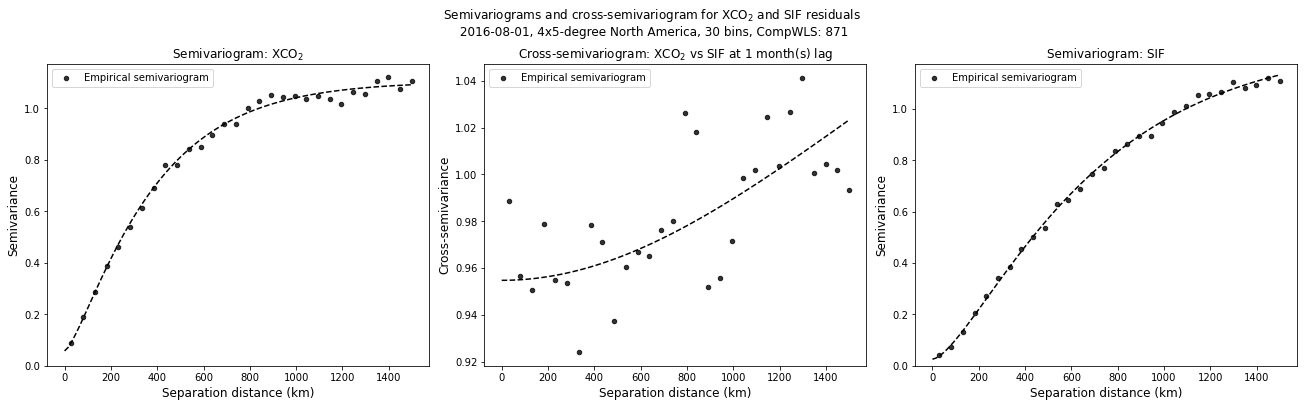

In [6]:
plot.plot_variograms(mod.fit_result, ["XCO$_2$", "SIF"])

## Prediction
---

In [7]:
import data_utils as du
import spatial_tools as st

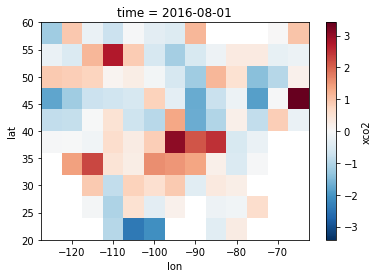

In [8]:
mf.fields[0].ds_main[mf.fields[0].data_name].T.plot()

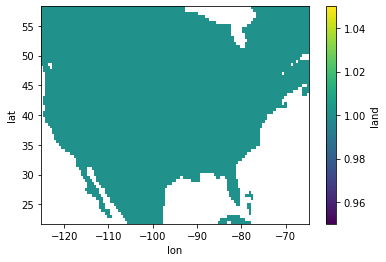

In [9]:
pred_grid = du.GridConfig(extents=(-125, -65, 22, 58), lon_res=0.5, lat_res=0.5)
df = du.land_grid(pred_grid)
df.to_xarray().land.T.plot()

In [10]:
pcoords = prediction.prediction_coords()
pcoords

array([[  48.5, -125. ],
       [  49. , -125. ],
       [  49.5, -125. ],
       ...,
       [  57. ,  -65. ],
       [  57.5,  -65. ],
       [  58. ,  -65. ]])

In [11]:
pcon = prediction.PredConfig(pcoords, 1e3)
P = prediction.Pred(mod, mf, pcon)

In [78]:
lv, lc = P._local_values(pcoords[-1], 1000)